In [65]:
import os
import numpy as np
import pandas as pd
import json
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Define Functions

In [66]:
def load_scikit_metrics(root_dir='./saved_models/traditional_models/'):
    # Initialize a list to store all performance data
    all_metrics = []

    # Walk through the directory structure
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file == 'cross_validated_performance_metrics.json':
                file_path = os.path.join(root, file)
                with open(file_path, 'r') as f:
                    data = json.load(f)
                
                # Extract the directory path to parse model details
                path_parts = root.split(os.sep)
                data['model_name'] = path_parts[-3]  # model_name_full from path
                data['df_selector'] = path_parts[-2]  # df_selector.value from path
                trained_subset_str = path_parts[-1]  # 'trained_on_X%_subset'

                # Extract the training subset percentage
                trained_subset_str = trained_subset_str.replace('trained_on_', '').replace('_subset', '')
                data['trained_subset'] = trained_subset_str  # This should now be 'X%'

                # Append the dictionary to the list
                all_metrics.append(data)

    # Convert the list of dictionaries to a DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    return metrics_df

# Load the metrics and display the DataFrame


In [67]:
def load_PyTorch_metrics(root_dir):
    all_metrics = []
    remove_segment = './saved_models/'  # Updated to be more specific to your usage

    # Walk through the directory structure
    for root, dirs, files in os.walk(root_dir):
        for file in files:
            if file.endswith('_metrics.txt'):  # Assuming the metrics are stored in text files with this naming convention
                file_path = os.path.join(root, file)
                model_metrics = {
                    'model_name': None,
                    'path': None,  # Initialize with None
                    'accuracy': None,
                    'precision': None,
                    'recall': None,
                    'f1': None,
                    'auc_roc': None,
                    'auprc': None
                }
                
                # Extract model name from the filename, excluding the '_metrics.txt'
                file_model_name = file.replace('_metrics.txt', '')
                model_metrics['model_name'] = file_model_name

                # Remove the './saved_models/' segment from the path
                if root.startswith(remove_segment):
                    model_metrics['path'] = root[len(remove_segment):]

                # Read the metrics from the text file
                with open(file_path, 'r') as f:
                    lines = f.readlines()
                    for line in lines:
                        if "Accuracy:" in line:
                            model_metrics['accuracy'] = float(line.split(':')[1].strip())
                        elif "Precision:" in line:
                            model_metrics['precision'] = float(line.split(':')[1].strip())
                        elif "Recall:" in line:
                            model_metrics['recall'] = float(line.split(':')[1].strip())
                        elif "F1 Score:" in line:
                            model_metrics['f1'] = float(line.split(':')[1].strip())
                        elif "AUC-ROC:" in line:
                            model_metrics['auc_roc'] = float(line.split(':')[1].strip())
                        elif "AUROC:" in line:
                            model_metrics['auc_roc'] = float(line.split(':')[1].strip())
                        elif "AUPRC:" in line:
                            model_metrics['auprc'] = float(line.split(':')[1].strip())

                # Append the dictionary to the list
                all_metrics.append(model_metrics)

    # Convert the list of dictionaries to a DataFrame
    metrics_df = pd.DataFrame(all_metrics)
    return metrics_df

In [68]:
# Creat "trained_on" column for the PyTorch Metrics
def add_trained_on_column(df, path_column):
     # Ensure the path column exists in the DataFrame
    if path_column in df.columns:
        df['trained_on'] = df[path_column].str.split('_').str[-1]
    else:
        raise ValueError(f"The specified column '{path_column}' does not exist in the DataFrame.")
    return df

In [69]:
def extract_model_name(full_path):
    # Split the full path into parts separated by '/'
    path_parts = full_path.split('/')
    # The actual model name is located at a specific index based on your path logic
    if len(path_parts) > 1:
        return path_parts[3]  # Adjust the index according to your directory structure
    else:
        return full_path  # Returns the input if the path is not as expected

In [70]:
def plot_performance_metrics_by_selector(filtered_metrics, filename):
    # Create the directory if it does not exist
    os.makedirs("./figures", exist_ok=True)

    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    filtered_metrics = filtered_metrics.copy()

    # Define the custom sort order for 'trained_on'
    sort_order = ['1%', '5%', '10%', '25%']
    filtered_metrics['sort_key'] = filtered_metrics['trained_on'].apply(lambda x: sort_order.index(x))

    # Get all unique df_selector values from the filtered_metrics DataFrame
    unique_selectors = filtered_metrics['df_selector'].unique()

    # Set the figure size for better visibility
    plt.figure(figsize=(12, 8))

    # Use a color map for clarity
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_selectors)))

    # To store custom legend handles
    legend_handles = []

    # Loop through each unique df_selector and plot their metrics
    for i, selector in enumerate(unique_selectors):
        # Filter and sort the data by 'trained_on' to ensure correct order on the plot
        selector_data = filtered_metrics[filtered_metrics['df_selector'] == selector]
        selector_data = selector_data.sort_values(by='trained_on')
        
        # Plot AUC-ROC for each df_selector (solid line)
        line1, = plt.plot(selector_data['trained_on'], selector_data['auc_roc'], marker='o', color=colors[i], linestyle='-')
        # Plot AUPRC for each df_selector (dotted line)
        plt.plot(selector_data['trained_on'], selector_data['auprc'], marker='x', linestyle='--', color=colors[i])

        # Add only one handle per df_selector for legend
        legend_handles.append(line1)

    # Adding labels and title
    plt.xlabel('Trained On')
    plt.ylabel('Metric Value')
    #plt.title(f'Performance Metrics Across Different Feature Sets for {filename}')

    # Add custom legend for df_selectors only
    plt.legend(handles=legend_handles, labels=[selector for selector in unique_selectors], title="Data Selectors", loc='upper left')

    # Annotation for line styles
    plt.text(0.05, 0.1, 'Solid line: AUROC\nDashed line: AUPRC', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.9))

    plt.grid(True)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"./figures/{filename}.png")  # Save the figure to the figures directory

    # Show the plot
    plt.show()

In [71]:
def plot_performance_metrics_for_subset_sizes(filtered_metrics, filename):
    # Create the directory if it does not exist
    os.makedirs("./figures", exist_ok=True)

    # Make a copy of the DataFrame to avoid SettingWithCopyWarning
    filtered_metrics = filtered_metrics.copy()

    # Define the custom sort order for 'trained_on'
    sort_order = ['1%', '5%', '10%', '25%']
    filtered_metrics['sort_key'] = filtered_metrics['trained_on'].apply(lambda x: sort_order.index(x))

    # Get all unique model names from the filtered_metrics DataFrame
    unique_models = filtered_metrics['model_name'].unique()

    # Set the figure size for better visibility
    plt.figure(figsize=(12, 8))

    # Use a color map for clarity
    colors = plt.cm.viridis(np.linspace(0, 1, len(unique_models)))

    # To store custom legend handles
    legend_handles = []

    # Loop through each unique model and plot their metrics
    for i, model in enumerate(unique_models):
        # Filter and sort the model data by the new sort key to ensure correct order on the plot
        model_data = filtered_metrics[filtered_metrics['model_name'] == model]
        model_data = model_data.sort_values(by='sort_key')
        
        # Plot AUC-ROC for each model (solid line)
        line1, = plt.plot(model_data['trained_on'], model_data['auc_roc'], marker='o', color=colors[i], linestyle='-')
        # Plot AUPRC for each model (dotted line)
        plt.plot(model_data['trained_on'], model_data['auprc'], marker='x', linestyle='--', color=colors[i])

        # Add only one handle per model for legend
        legend_handles.append(line1)

    # Adding labels and title
    plt.xlabel('Trained On')
    plt.ylabel('Metric Value')
    #plt.title(f'Performance Metrics Across Different Training Sizes for {filename}')

    # Add custom legend for model names only
    plt.legend(handles=legend_handles, labels=[model for model in unique_models], title="Models", loc='upper left')

    # Annotation for line styles
    plt.text(0.05, 0.1, 'Solid line: AUROC\nDashed line: AUPRC', transform=plt.gca().transAxes, fontsize=12, verticalalignment='bottom', bbox=dict(boxstyle="round,pad=0.3", edgecolor='gray', facecolor='white', alpha=0.9))

    plt.grid(True)

    # Adjust layout and save the figure
    plt.tight_layout()
    plt.savefig(f"./figures/{filename}.png")  # Save the figure to the figures directory

    # Show the plot
    plt.show()

# Load and Merge all Metrics

In [72]:
# Load the scikit Metrics
scikit_metrics = load_scikit_metrics()

# Extract the Dictionary with the basic metrics
basic_metrics = scikit_metrics['cv_results'].apply(pd.Series)
scikit_metrics = scikit_metrics.join(basic_metrics)

# Apply this function to the 'model_name' column of your DataFrame
scikit_metrics['model_name'] = scikit_metrics['model_name'].apply(extract_model_name)

# Filter the DataFrame for entries where 'model_name' contains 'with_oversampling'
oversampled_scikit_metrics = scikit_metrics[scikit_metrics['model_name'].str.contains('with_oversampling')]

# Ensure 'oversampling_models' is treated as a standalone DataFrame, not a slice
oversampled_scikit_metrics = oversampled_scikit_metrics.copy()

# Remove '_with_oversampling' from the slice 
oversampled_scikit_metrics.loc[:, 'model_name'] = oversampled_scikit_metrics['model_name'].str.replace('_with_oversampling', '', regex=False)

# Remove 'Classifier' from the slice 
oversampled_scikit_metrics.loc[:, 'model_name'] = oversampled_scikit_metrics['model_name'].str.replace('Classifier', '', regex=False)

# Load all PyTorch Metrics
hybrid_lstm_metrics = load_PyTorch_metrics('./saved_models/Hybrid_LSTM/')
hybrid_med_bert_metrics = load_PyTorch_metrics('./saved_models/Hybrid_Med-BERT/')
med_bert_metrics = load_PyTorch_metrics('./saved_models/Med-BERT/')
LSTM_metrics = load_PyTorch_metrics('./saved_models/LSTM/')

# Create 'traind_on' column
hybrid_lstm_metrics = add_trained_on_column(hybrid_lstm_metrics, 'path')
hybrid_med_bert_metrics = add_trained_on_column(hybrid_med_bert_metrics, 'path')
med_bert_metrics = add_trained_on_column(med_bert_metrics, 'path')
LSTM_metrics = add_trained_on_column(LSTM_metrics, 'path')

# Load TFT Metrics
TFT_metrics = load_PyTorch_metrics('./saved_models/TFT-Model/')

# Extracting the substring after 'on ' for each model name and creating a new column 'trained_on'
TFT_metrics['trained_on'] = TFT_metrics['model_name'].apply(lambda x: x.split("on ")[-1])
# Updating 'model_name' to only keep 'TFT Model' and discard other details
TFT_metrics['model_name'] = TFT_metrics['model_name'].str.replace(' - Trained on.*', '', regex=True)

# Concatenate all PyTorch Metrics
PyTorch_metrics = pd.concat([hybrid_lstm_metrics, hybrid_med_bert_metrics, med_bert_metrics, LSTM_metrics, TFT_metrics], ignore_index=True)

In [73]:
# Rename columns in scikit_metrics if needed to match PyTorch_metrics
oversampled_scikit_metrics = oversampled_scikit_metrics.rename(columns={
    'auc_roc_cv': 'auc_roc',
    'auprc_cv': 'auprc',
    'trained_subset' : 'trained_on'
})

# Add the 'df_selector' column to the PyTorch_metrics DataFrame
PyTorch_metrics['df_selector'] = None  # or use '' for an empty string

# Select relevant columns from both DataFrames to ensure they are aligned
columns_to_use = ['model_name', 'auc_roc', 'auprc', 'trained_on', 'df_selector', 'accuracy', 'precision', 'recall', 'f1']

# Since we renamed scikit_metrics, we directly select the renamed columns
all_metrics = pd.concat([
    PyTorch_metrics[columns_to_use],
    oversampled_scikit_metrics[columns_to_use]
], ignore_index=True)

# Define percentage values to keep
percentage_values = ['1%', '5%', '10%', '25%']

# Filter the DataFrame to include only the specified percentage values
all_metrics = all_metrics[all_metrics['trained_on'].isin(percentage_values)]

In [74]:
# Save the combined metrics
all_metrics.to_csv('all_performance_metrics.csv')

# Compare Traditional Models Along different Feature Sets

In [75]:
# Filter the DataFrame for the specific 'df_selector' value
rf_metrics = all_metrics[all_metrics['model_name'] == "RandomForest"]
gb_metrics = all_metrics[all_metrics['model_name'] == "GradientBoosting"]
MLP_metrics = all_metrics[all_metrics['model_name'] == "MLP"]
lr_metrics = all_metrics[all_metrics['model_name'] == "LogisticRegression"]
lstm_metrics = all_metrics[all_metrics['model_name'].str.contains("LSTM", case=False, na=False)]

In [76]:
# Update df_selector for Hybrid_LSTM
lstm_metrics.loc[lstm_metrics['model_name'] == "Hybrid_LSTM", 'df_selector'] = "Hybrid"
# Update df_selector for LSTM_Only_Dynamic_Features
lstm_metrics.loc[lstm_metrics['model_name'] == "LSTM_Only_Dynamic_Features", 'df_selector'] = "Dynamic"
# Update df_selector for LSTM_Repeating_Static_Features
lstm_metrics.loc[lstm_metrics['model_name'] == "LSTM_Repeating_Static_Features", 'df_selector'] = "Repeating Static & Dynamic"

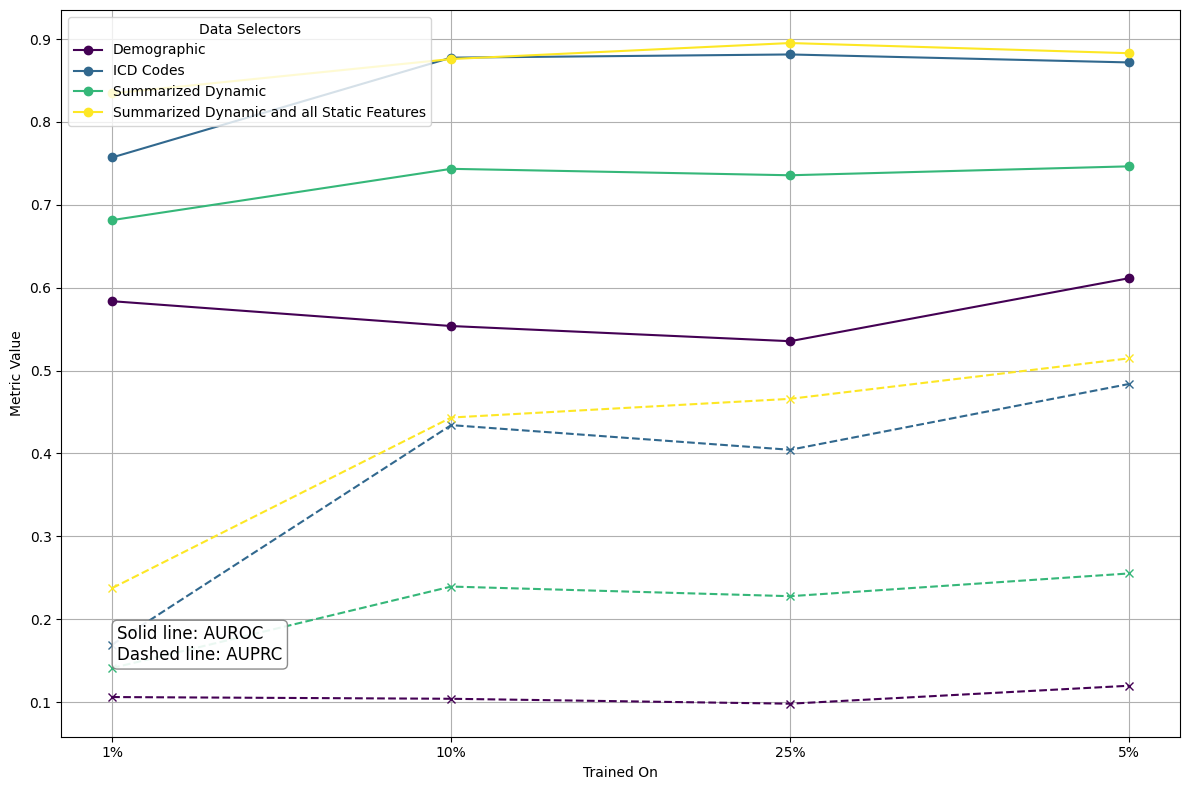

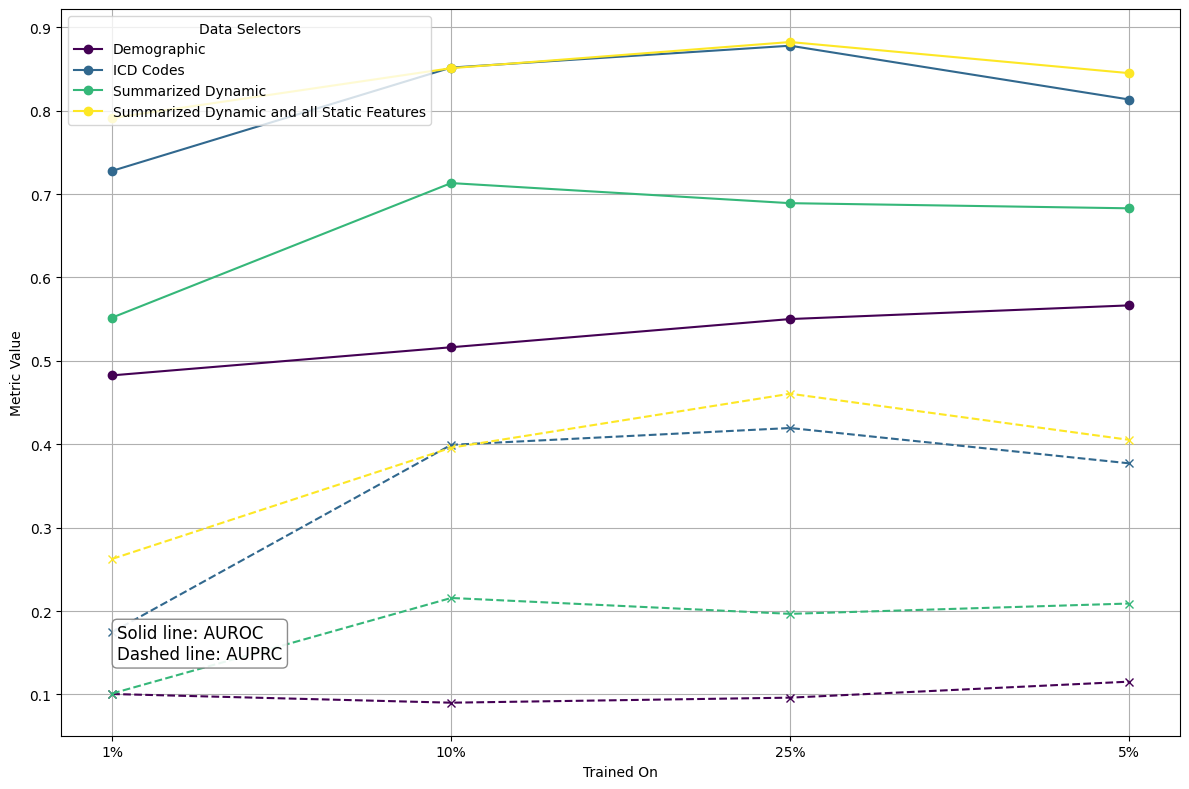

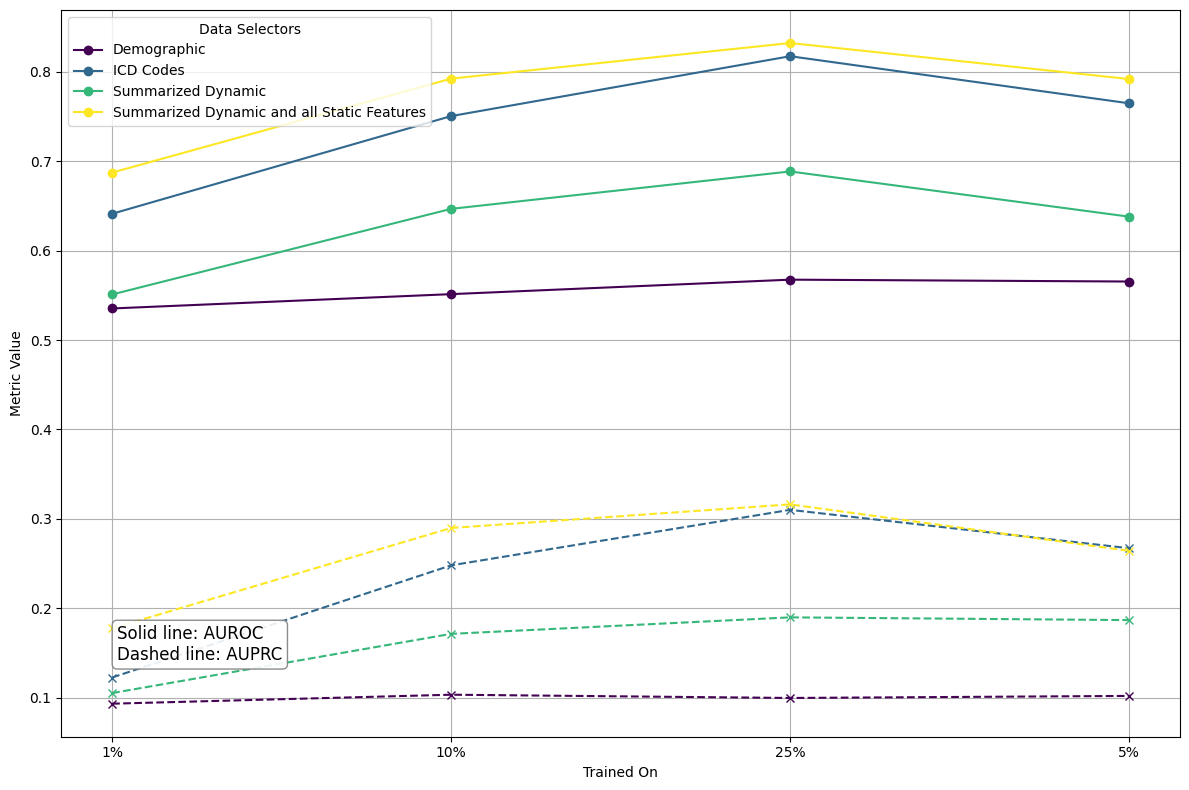

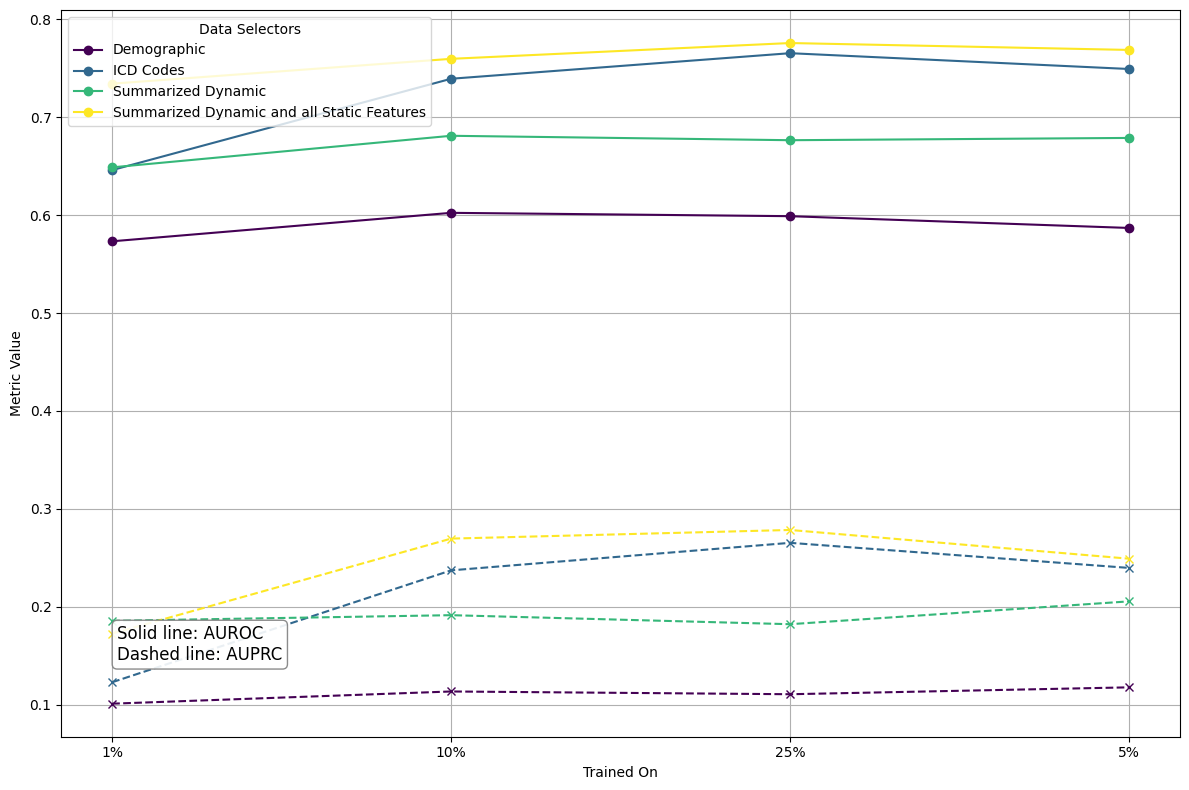

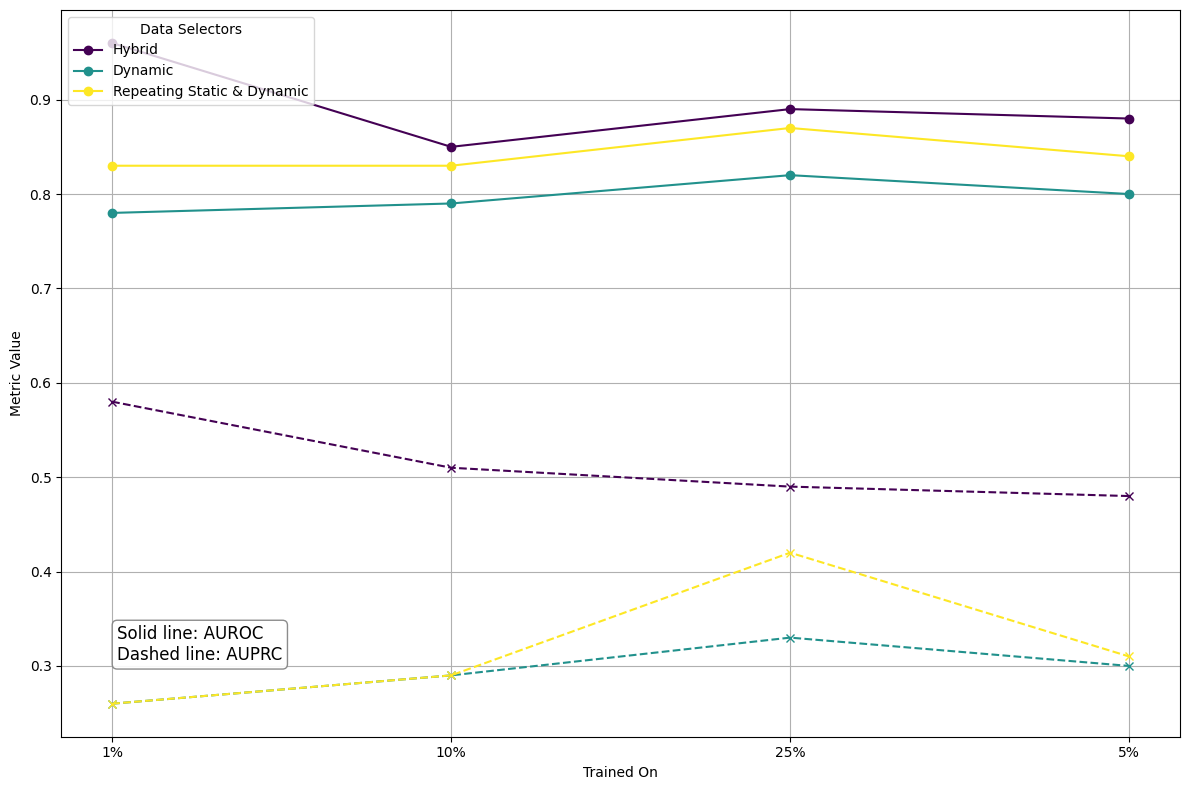

In [77]:
plot_performance_metrics_by_selector(rf_metrics, 'RandomForest')
plot_performance_metrics_by_selector(gb_metrics, 'Gradient Boosting')
plot_performance_metrics_by_selector(MLP_metrics, 'Multi Level Perceptron')
plot_performance_metrics_by_selector(lr_metrics, 'Logistic Regression')
plot_performance_metrics_by_selector(lstm_metrics, 'LSTM')

# All Traditional Models Over Training Data Amount

In [78]:
# Filter the DataFrame for rows with scikit-learn models trained on all Features
filtered_metrics = all_metrics[all_metrics['df_selector'] == "Summarized Dynamic and all Static Features"]

# Add the PyTorch models
pytorch_metrics_add = all_metrics[all_metrics['model_name'].isin(['Hybrid_LSTM'])]

# Concatenate this filtered data with the 'filtered_metrics' DataFrame
# reindex to avoid duplicate indices
filtered_metrics = pd.concat([filtered_metrics, pytorch_metrics_add], ignore_index=True)

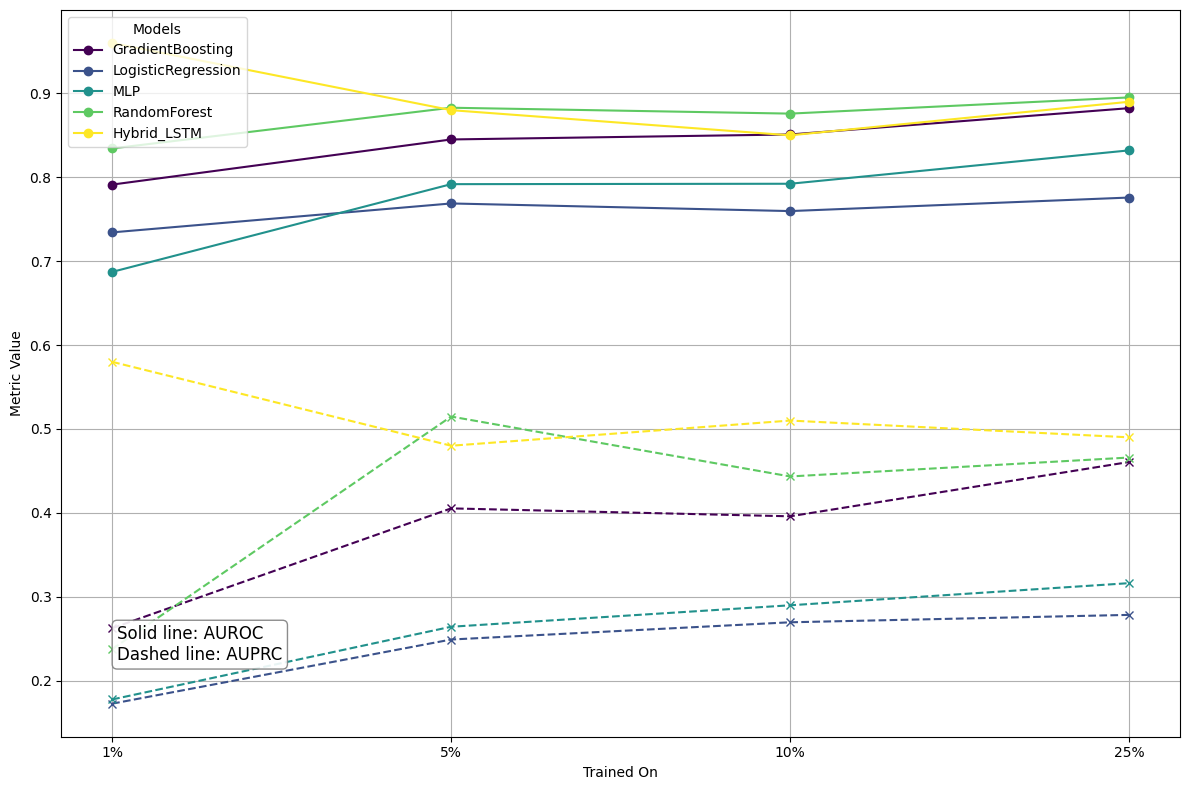

In [79]:
plot_performance_metrics_for_subset_sizes(filtered_metrics, 'All Traditional Models Trained on All Features')

# All Models compared Over Training Data Amount (Best Configuration)

In [80]:
# Filter the DataFrame for rows with scikit-learn models trained on all Features
filtered_metrics = all_metrics[all_metrics['df_selector'] == "Summarized Dynamic and all Static Features"]

# Select best and worst model
filtered_metrics = filtered_metrics[filtered_metrics['model_name'].isin(['RandomForest', 'LogisticRegression'])]

# Add the PyTorch models
pytorch_metrics_add = all_metrics[all_metrics['model_name'].isin(['Hybrid_LSTM', 'Med-BERT', 'TFT Model'])]

# Concatenate this filtered data with the 'filtered_metrics' DataFrame
# reindex to avoid duplicate indices
filtered_metrics = pd.concat([filtered_metrics, pytorch_metrics_add], ignore_index=True)

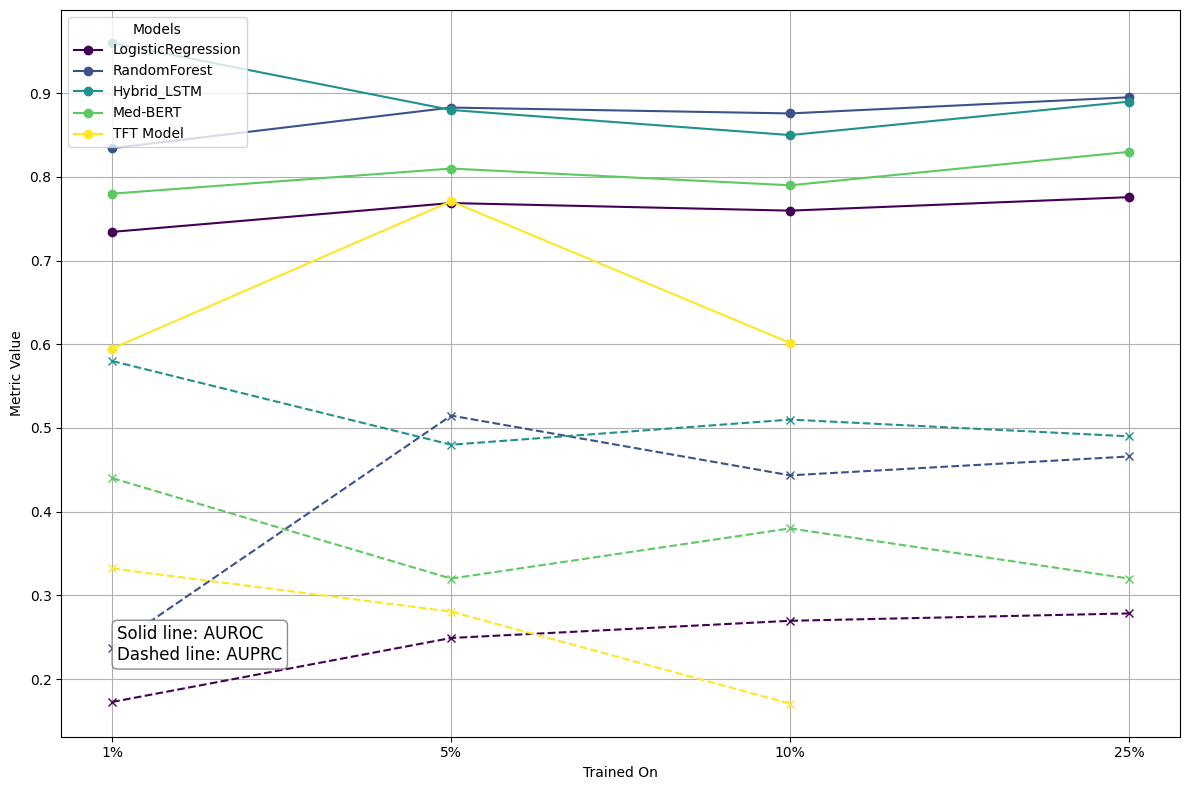

In [81]:
plot_performance_metrics_for_subset_sizes(filtered_metrics, 'Best Configuration of Main Models (Only ICD Codes)')

# All Models compared Over Training Data Amount (Only ICD Codes)

In [82]:
# Filter the DataFrame for rows with scikit-learn models trained on all Features
filtered_metrics = all_metrics[all_metrics['df_selector'] == "ICD Codes"]

# Select best and worst model
filtered_metrics = filtered_metrics[filtered_metrics['model_name'].isin(['RandomForest', 'LogisticRegression'])]

# Add the PyTorch models
pytorch_metrics_add = all_metrics[all_metrics['model_name'].isin(['Med-BERT'])]

# Concatenate this filtered data with the 'filtered_metrics' DataFrame
# reindex to avoid duplicate indices
filtered_metrics = pd.concat([filtered_metrics, pytorch_metrics_add], ignore_index=True)

In [83]:
filtered_metrics

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
0,LogisticRegression,0.646023,0.122813,1%,ICD Codes,0.870511,0.065000,0.080000,0.070769
1,LogisticRegression,0.739346,0.237129,10%,ICD Codes,0.844745,0.246606,0.424091,0.311063
2,LogisticRegression,0.765454,0.265233,25%,ICD Codes,0.838337,0.266169,0.541405,0.356773
3,LogisticRegression,0.749302,0.239611,5%,ICD Codes,0.859459,0.273748,0.420370,0.329450
4,RandomForest,0.757134,0.169481,1%,ICD Codes,0.909679,0.000000,0.000000,0.000000
5,RandomForest,0.877535,0.434230,10%,ICD Codes,0.921922,0.564230,0.286364,0.376785
6,RandomForest,0.881398,0.404459,25%,ICD Codes,0.920130,0.599585,0.114673,0.191923
7,RandomForest,0.871779,0.483883,5%,ICD Codes,0.928529,0.675128,0.274868,0.389559
8,Med-BERT,0.780000,0.440000,1%,None,0.790000,0.200000,0.500000,0.290000
9,Med-BERT,0.790000,0.380000,10%,None,0.710000,0.180000,0.690000,0.280000


In [84]:
all_metrics["df_selector"].unique()

array([None, 'Demographic', 'ICD Codes', 'Summarized Dynamic',
       'Summarized Dynamic and all Static Features'], dtype=object)

In [85]:
filtered_metrics

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
0,LogisticRegression,0.646023,0.122813,1%,ICD Codes,0.870511,0.065000,0.080000,0.070769
1,LogisticRegression,0.739346,0.237129,10%,ICD Codes,0.844745,0.246606,0.424091,0.311063
2,LogisticRegression,0.765454,0.265233,25%,ICD Codes,0.838337,0.266169,0.541405,0.356773
3,LogisticRegression,0.749302,0.239611,5%,ICD Codes,0.859459,0.273748,0.420370,0.329450
4,RandomForest,0.757134,0.169481,1%,ICD Codes,0.909679,0.000000,0.000000,0.000000
5,RandomForest,0.877535,0.434230,10%,ICD Codes,0.921922,0.564230,0.286364,0.376785
6,RandomForest,0.881398,0.404459,25%,ICD Codes,0.920130,0.599585,0.114673,0.191923
7,RandomForest,0.871779,0.483883,5%,ICD Codes,0.928529,0.675128,0.274868,0.389559
8,Med-BERT,0.780000,0.440000,1%,None,0.790000,0.200000,0.500000,0.290000
9,Med-BERT,0.790000,0.380000,10%,None,0.710000,0.180000,0.690000,0.280000


In [86]:
# Filter the DataFrame for rows with scikit-learn models trained on all Features
filtered_metrics = all_metrics[all_metrics['df_selector'] == "ICD Codes"]

# Select best and worst model
filtered_metrics = filtered_metrics[filtered_metrics['model_name'].isin(['RandomForest', 'LogisticRegression'])]

# Add the PyTorch models
pytorch_metrics_add = all_metrics[all_metrics['model_name'].isin(['Med-BERT'])]

# Concatenate this filtered data with the 'filtered_metrics' DataFrame
# reindex to avoid duplicate indices
filtered_metrics = pd.concat([filtered_metrics, pytorch_metrics_add], ignore_index=True)

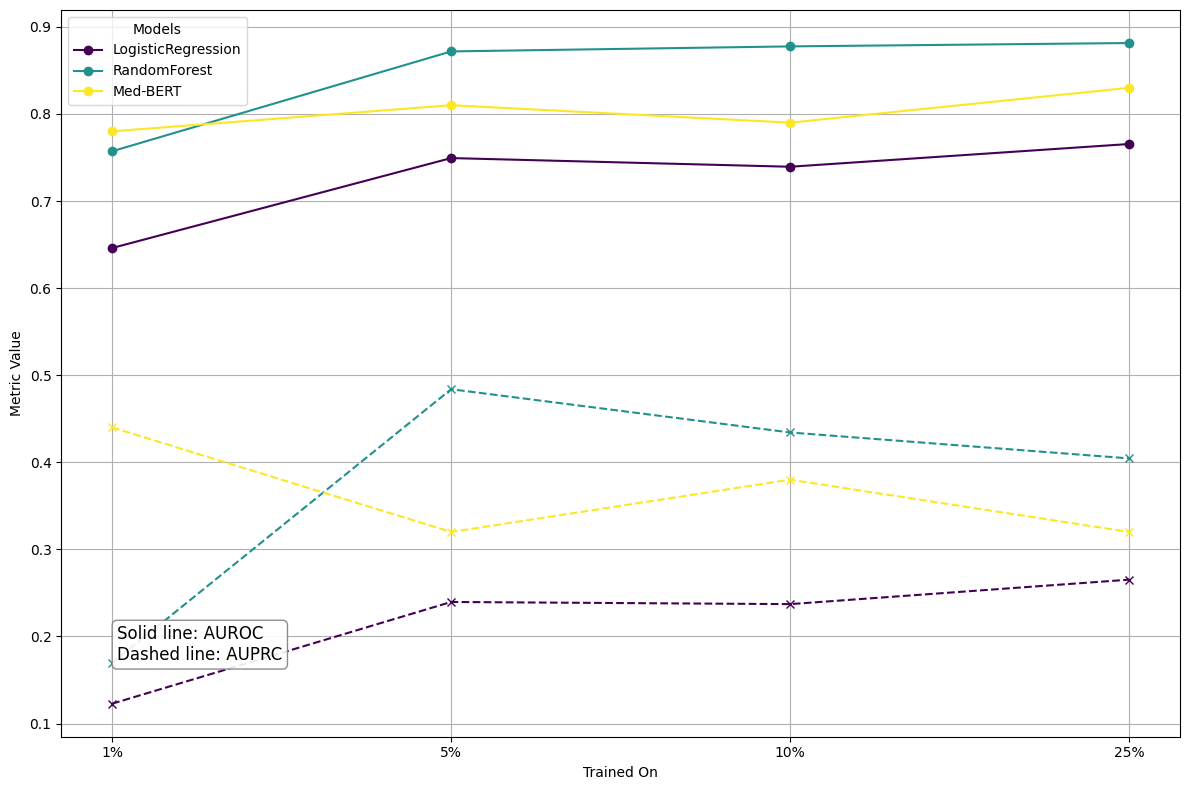

In [87]:
plot_performance_metrics_for_subset_sizes(filtered_metrics, 'Only Using ICD Codes')

# Create Tables

In [96]:
all_metrics

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
0,Hybrid_LSTM,0.960000,0.580000,1%,None,0.890000,0.420000,0.830000,0.560000
1,Hybrid_LSTM,0.850000,0.510000,10%,None,0.830000,0.280000,0.690000,0.400000
2,Hybrid_LSTM,0.890000,0.490000,25%,None,0.880000,0.380000,0.720000,0.500000
3,Hybrid_LSTM,0.880000,0.480000,5%,None,0.700000,0.210000,0.900000,0.340000
4,Hybrid_Med_BERT,0.641000,0.140000,1%,None,0.577500,0.125000,0.666700,0.210500
...,...,...,...,...,...,...,...,...,...
87,RandomForest,0.746424,0.255302,5%,Summarized Dynamic,0.903303,0.329145,0.152116,0.206528
88,RandomForest,0.834366,0.237575,1%,Summarized Dynamic and all Static Features,0.906649,0.000000,0.000000,0.000000
89,RandomForest,0.875872,0.443376,10%,Summarized Dynamic and all Static Features,0.919520,0.528812,0.380584,0.440506
90,RandomForest,0.895182,0.465940,25%,Summarized Dynamic and all Static Features,0.924694,0.598326,0.274347,0.375839


In [88]:
all_features_25 = all_metrics[
    (all_metrics['trained_on'] == '25%') &
    (all_metrics['df_selector'].isin([None, 'Summarized Dynamic and all Static Features']))
]

In [89]:
all_features_25

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
2,Hybrid_LSTM,0.890000,0.490000,25%,None,0.880000,0.380000,0.720000,0.500000
11,Med-BERT,0.830000,0.320000,25%,None,0.770000,0.230000,0.750000,0.350000
16,LSTM_Only_Dynamic_Features,0.820000,0.330000,25%,None,0.780000,0.240000,0.730000,0.360000
20,LSTM_Repeating_Static_Features,0.870000,0.420000,25%,None,0.850000,0.310000,0.660000,0.430000
39,GradientBoosting,0.882373,0.460632,25%,Summarized Dynamic and all Static Features,0.924934,0.613701,0.251084,0.355970
56,LogisticRegression,0.775831,0.278383,25%,Summarized Dynamic and all Static Features,0.845303,0.280696,0.554491,0.372382
73,MLP,0.832061,0.316220,25%,Summarized Dynamic and all Static Features,0.898631,0.384647,0.372972,0.378317
90,RandomForest,0.895182,0.465940,25%,Summarized Dynamic and all Static Features,0.924694,0.598326,0.274347,0.375839


In [90]:
all_features_10 = all_metrics[
    (all_metrics['trained_on'] == '10%') &
    (all_metrics['df_selector'].isin([None, 'Summarized Dynamic and all Static Features']))
]

In [91]:
all_features_10

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
1,Hybrid_LSTM,0.850000,0.510000,10%,None,0.830000,0.280000,0.690000,0.400000
5,Hybrid_Med_BERT,0.669700,0.140000,10%,None,0.677900,0.148100,0.610200,0.238400
10,Med-BERT,0.790000,0.380000,10%,None,0.710000,0.180000,0.690000,0.280000
15,LSTM_Only_Dynamic_Features,0.790000,0.290000,10%,None,0.810000,0.240000,0.610000,0.340000
19,LSTM_Repeating_Static_Features,0.830000,0.290000,10%,None,0.770000,0.230000,0.780000,0.360000
23,TFT Model,0.601600,0.170500,10%,None,0.602200,0.121200,0.610200,0.202200
38,GradientBoosting,0.851014,0.395878,10%,Summarized Dynamic and all Static Features,0.917718,0.519218,0.202922,0.288787
55,LogisticRegression,0.759697,0.269563,10%,Summarized Dynamic and all Static Features,0.860060,0.281851,0.445649,0.345025
72,MLP,0.792269,0.289826,10%,Summarized Dynamic and all Static Features,0.901802,0.395610,0.344221,0.367309
89,RandomForest,0.875872,0.443376,10%,Summarized Dynamic and all Static Features,0.919520,0.528812,0.380584,0.440506


In [92]:
all_features_5 = all_metrics[
    (all_metrics['trained_on'] == '5%') &
    (all_metrics['df_selector'].isin([None, 'Summarized Dynamic and all Static Features']))
]

In [93]:
all_features_5

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
3,Hybrid_LSTM,0.880000,0.480000,5%,None,0.700000,0.210000,0.900000,0.340000
6,Hybrid_Med_BERT,0.670000,0.210000,5%,None,0.731100,0.182700,0.633300,0.283600
12,Med-BERT,0.810000,0.320000,5%,None,0.660000,0.180000,0.870000,0.300000
17,LSTM_Only_Dynamic_Features,0.800000,0.300000,5%,None,0.830000,0.260000,0.600000,0.370000
21,LSTM_Repeating_Static_Features,0.840000,0.310000,5%,None,0.820000,0.270000,0.670000,0.380000
24,TFT Model,0.770900,0.280500,5%,None,0.689100,0.186000,0.800000,0.301900
40,GradientBoosting,0.845064,0.405319,5%,Summarized Dynamic and all Static Features,0.921922,0.587631,0.291005,0.376136
57,LogisticRegression,0.768785,0.249015,5%,Summarized Dynamic and all Static Features,0.864865,0.271999,0.376720,0.313919
74,MLP,0.791791,0.264244,5%,Summarized Dynamic and all Static Features,0.870871,0.300202,0.398148,0.340735
91,RandomForest,0.882891,0.514792,5%,Summarized Dynamic and all Static Features,0.927327,0.612879,0.348942,0.436990


In [94]:
all_features_1= all_metrics[
    (all_metrics['trained_on'] == '1%') &
    (all_metrics['df_selector'].isin([None, 'Summarized Dynamic and all Static Features']))
]

In [95]:
all_features_1

,model_name,auc_roc,auprc,trained_on,df_selector,accuracy,precision,recall,f1
0,Hybrid_LSTM,0.960000,0.580000,1%,None,0.890000,0.420000,0.830000,0.560000
4,Hybrid_Med_BERT,0.641000,0.140000,1%,None,0.577500,0.125000,0.666700,0.210500
8,Med-BERT,0.780000,0.440000,1%,None,0.790000,0.200000,0.500000,0.290000
9,tuned-Med-BERT,0.780000,0.440000,1%,None,0.800000,0.210000,0.500000,0.300000
14,LSTM_Only_Dynamic_Features,0.780000,0.260000,1%,None,0.690000,0.170000,0.670000,0.270000
18,LSTM_Repeating_Static_Features,0.830000,0.260000,1%,None,0.770000,0.220000,0.670000,0.330000
22,TFT Model,0.594900,0.332100,1%,None,0.873200,0.285700,0.333300,0.307700
37,GradientBoosting,0.791257,0.262525,1%,Summarized Dynamic and all Static Features,0.897512,0.296667,0.213333,0.242424
54,LogisticRegression,0.734305,0.172532,1%,Summarized Dynamic and all Static Features,0.885572,0.197143,0.153333,0.156667
71,MLP,0.687189,0.177557,1%,Summarized Dynamic and all Static Features,0.783130,0.164737,0.366667,0.219497
